# I. 데이터 불러오기

In [1]:
# 모듈 import
import sqlite3
import pandas as pd
import numpy as np
from collections import defaultdict

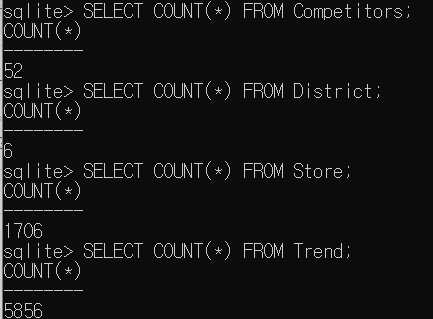

In [2]:
# store db, district db, competitors db 불러오기
conn = sqlite3.connect("./data/eatsite.db") # eatsite.db가 저장되어 있는 경로로 지정하면 됨.

try:
    sql_query1 = pd.read_sql_query ('''SELECT * FROM Store;''', conn)
    sql_query2 = pd.read_sql_query ('''SELECT * FROM District;''', conn)
    sql_query3 = pd.read_sql_query ('''SELECT * FROM Competitors;''', conn)

    df_store = pd.DataFrame(sql_query1)
    df_district = pd.DataFrame(sql_query2)
    df_competitors = pd.DataFrame(sql_query3)

except sqlite3.Error as err:
    print('SQLite ERROR:', err)
finally:  
    conn.close()  

# II. 생활인구 - 성비, 연령 분석

In [3]:
# 성비는 남성/여성 비율로, 각 연령대 인구 비율은 각 연령대 인구 수를 전체 인구 수로 나누었음. 
demographic_df = pd.DataFrame(columns = ['상권 이름', '성비', '10대 인구 비율', '20대 인구 비율', '30대 인구 비율', '40대 인구 비율', '50대 인구 비율','60대 인구 비율'])

for i in range(len(df_district)):
    demographic_df = demographic_df.append(
                    pd.Series([df_district.loc[i, 'category'], round(df_district.loc[i, 'pop_m']/df_district.loc[i, 'pop_f'] * 100, 2), 
                               f"{df_district.loc[i, 'pop_10']/df_district.loc[i, 'pop_total'] * 100:.2f}" + "%", 
                               f"{df_district.loc[i, 'pop_20']/df_district.loc[i, 'pop_total'] * 100:.2f}" + "%",
                               f"{df_district.loc[i, 'pop_30']/df_district.loc[i, 'pop_total'] * 100:.2f}" + "%",
                               f"{df_district.loc[i, 'pop_40']/df_district.loc[i, 'pop_total'] * 100:.2f}" + "%",
                               f"{df_district.loc[i, 'pop_50']/df_district.loc[i, 'pop_total'] * 100:.2f}" + "%",
                               f"{df_district.loc[i, 'pop_60']/df_district.loc[i, 'pop_total'] * 100:.2f}" + "%"],
                              index = demographic_df.columns), ignore_index=True)

In [4]:
# 결과
demographic_df

,상권 이름,성비,10대 인구 비율,20대 인구 비율,30대 인구 비율,40대 인구 비율,50대 인구 비율,60대 인구 비율
0,인사동,118.06,4.86%,17.21%,20.96%,20.36%,16.91%,19.70%
1,서래마을카페거리(서래마을),80.59,23.62%,9.12%,12.40%,19.98%,14.20%,20.69%
2,서울대입구역,91.71,7.28%,37.90%,20.59%,11.21%,9.72%,13.30%
3,연남동(홍대),82.62,8.80%,30.18%,22.45%,15.56%,10.01%,12.99%
4,남대문시장(자유상가),79.25,2.96%,13.64%,21.92%,20.54%,17.80%,23.14%
5,공릉동 도깨비시장,82.93,9.63%,21.63%,13.87%,12.47%,15.29%,27.12%


# III. (대분류에 따른) 메뉴 분석 - 가격대 

* 다른 업종별 분석도 대분류에 따른 것이 많아 메뉴 분석 역시 대분류에 따라서 했음.
* 소분류는 크게 쓸 데가 없을 것 같아 일단은 삭제함.

In [5]:
# 각 업종에서 어떤 음식이 메뉴에 많이 있나 선별하기 위한 코드. 
# rep_menu에는 업종별로 Top 5 음식들을 수록함.
rep_menu = defaultdict(str)
for category in list(df_store['category'].value_counts().index):
    ans_dict = defaultdict(str)
    
    # category가 제외인 경우는 자료 수집하지 않음.
    if category == '제외':
        continue
        
    current_df = df_store[df_store['category'] == category]
    
    for menus in current_df['menu']:
        if menus:
            menu_list = menus.split(',')
            for menu in menu_list:
                idx = menu.find(':')
                menu_name = menu[:idx]
                # 가격 평균을 내는 것이 목적이기에, 메뉴 가격이 '변동'인 경우 역시 제외함.
                if menu_name in ans_dict and not menu[idx+1:].startswith('변'):
                    ans_dict[menu_name] += 1
                else:
                    ans_dict[menu_name] = 1
                
    ans_dict = sorted(ans_dict.items(), key=lambda x:x[1], reverse=True)            
    
    rep_menu[category] = []
    
    # Top 5 (일부는 Top6)만 수록.
    for element in ans_dict[:6]:
        # 메뉴가 없는 경우도 제외하고 rep_menu에 수록
        if element[0] != '메뉴가 없습니':
            rep_menu[category].append(element[0])
    
    # Top10 출력
    print(category, ' ->\n',  ans_dict[:10], end = '\n\n')

한식음식점  ->
 [('메뉴가 없습니', 31), ('김치찌개', 20), ('해물파전', 19), ('된장찌개', 16), ('감자전', 10), ('제육볶음', 10), ('김치전', 10), ('순두부찌개', 8), ('물냉면', 8), ('비빔냉면', 8)]

호프-간이주점  ->
 [('먹태', 12), ('해물파전', 11), ('메뉴가 없습니', 11), ('감자튀김', 10), ('김치전', 9), ('두부김치', 9), ('노가리', 8), ('감자전', 8), ('칵테일', 8), ('치즈플레이트', 8)]

커피-음료  ->
 [('아메리카노', 53), ('카페라떼', 52), ('에스프레소', 27), ('카푸치노', 26), ('바닐라라떼', 26), ('메뉴가 없습니', 20), ('카페모카', 16), ('아인슈페너', 13), ('라떼', 13), ('플랫화이트', 12)]

양식음식점  ->
 [('아메리카노', 11), ('봉골레 파스타', 9), ('메뉴가 없습니', 8), ('감바스', 7), ('봉골레', 6), ('가리비관자구이', 6), ('고르곤졸라 피자', 5), ('알리오올리오', 5), ('레몬에이드', 5), ('채끝등심 200g', 5)]

고기구이  ->
 [('생삼겹살', 10), ('계란찜', 9), ('차돌박이', 8), ('볶음밥', 8), ('살치살', 7), ('김치찌개', 6), ('삼겹살', 6), ('메뉴가 없습니', 6), ('육회', 5), ('물냉면', 5)]

중식음식점  ->
 [('짜장면', 14), ('짬뽕', 11), ('메뉴가 없습니', 10), ('군만두', 8), ('마파두부', 8), ('볶음밥', 7), ('양꼬치', 7), ('짬뽕밥', 7), ('고급양갈비', 5), ('지삼선', 5)]

일식음식점  ->
 [('메뉴가 없습니', 8), ('사케동', 8), ('하이볼', 5), ('새우튀김', 4), ('부타동', 4), ('모츠나베', 4), ('돈까스',

In [6]:
# 업종 별로 상위 5개의 음식을 추출하였지만, 그 업종을 대표하지 못하는 경우는 제외
# 양식음식점에서 아메리카노 -> 고르곤졸라 피자
# 해외요리에서 아메리카노 -> 차돌양지 쌀국수
# 치킨에서 황금올리브치킨 ~ 은 BBQ만의 메뉴라는 점, 간식에서 파인트, 쿼터, 패밀리, 하프갤론은 베라의 사이즈라는 점 감안해야 함.
rep_menu['양식음식점'].remove('아메리카노')
rep_menu['양식음식점'].append('고르곤졸라 피자')
rep_menu['해외요리'].remove('아메리카노')
rep_menu['해외요리'].append('차돌양지 쌀국수')

In [7]:
# 업종 별로 대표 5개 메뉴를 선정하여 평균 가격을 추출하여 big_category_price_five 에 저장
# 또한 업종 별로 대표 1개 메뉴를 선정하여 평균 가격을 추출하여 big_category_price_one 에 저장

big_category_price_five = dict()
big_category_price_one = dict()

for category in list(df_store['category'].value_counts().index):
    
    total_price_five = 0
    total_menu_five = 0
    
    total_price_one = 0
    total_menu_one = 0
    
    # category가 제외인 경우는 자료를 수집하지 않음.
    if category == '제외':
        continue
        
    current_df = df_store[df_store['category'] == category]
    
    for menus in current_df['menu']:
        if menus:
            menu_list = menus.split(',')
            for menu in menu_list:
                idx = menu.find(':')
                menu_name = menu[:idx]
                # Top 5 메뉴를 추출
                if menu_name in rep_menu[category] and menu[idx+1] != '변':
                    idx2 = menu.find('~')
                    if idx2 != -1:
                        total_price_five += int(menu[idx+1:idx2])
                    else:
                        total_price_five += int(menu[idx+1:])
                    total_menu_five += 1
                    
                # 대표 1개 메뉴를 추출
                if menu_name == rep_menu[category][0] and menu[idx+1] != '변':
                    idx3 = menu.find('~')
                    if idx3 != -1:
                        total_price_one += int(menu[idx+1:idx3])
                    else:
                        total_price_one += int(menu[idx+1:])
                    total_menu_one += 1
    
    # 딕셔너리에 각각 Top5, 대표 1개 메뉴 평균 가격을 저장함.
    big_category_price_five[category] = int(total_price_five/total_menu_five)
    big_category_price_one[category] = int(total_price_one/total_menu_one)
    
    # 평균 가격과 해당 메뉴를 가지고 있는 음식점 수 출력
    print('Top5 ', category, ' --> ', '평균 가격 - ', int(total_price_five/total_menu_five), ', 음식점 수 - ', int(total_menu_five))
    print('Top1 ', category, ' --> ', '평균 가격 - ', int(total_price_one/total_menu_one), ', 음식점 수 - ', int(total_menu_one))
    print('-'*50)

Top5  한식음식점  -->  평균 가격 -  10920 , 음식점 수 -  75
Top1  한식음식점  -->  평균 가격 -  8275 , 음식점 수 -  20
--------------------------------------------------
Top5  호프-간이주점  -->  평균 가격 -  13480 , 음식점 수 -  51
Top1  호프-간이주점  -->  평균 가격 -  14000 , 음식점 수 -  12
--------------------------------------------------
Top5  커피-음료  -->  평균 가격 -  4463 , 음식점 수 -  238
Top1  커피-음료  -->  평균 가격 -  4209 , 음식점 수 -  104
--------------------------------------------------
Top5  양식음식점  -->  평균 가격 -  17251 , 음식점 수 -  33
Top1  양식음식점  -->  평균 가격 -  15988 , 음식점 수 -  9
--------------------------------------------------
Top5  고기구이  -->  평균 가격 -  13097 , 음식점 수 -  48
Top1  고기구이  -->  평균 가격 -  12890 , 음식점 수 -  10
--------------------------------------------------
Top5  중식음식점  -->  평균 가격 -  6800 , 음식점 수 -  48
Top1  중식음식점  -->  평균 가격 -  5678 , 음식점 수 -  14
--------------------------------------------------
Top5  일식음식점  -->  평균 가격 -  13092 , 음식점 수 -  25
Top1  일식음식점  -->  평균 가격 -  13612 , 음식점 수 -  8
---------------------------------------

# IV. 상권별 업종 분석 및 매출과의 상관분석

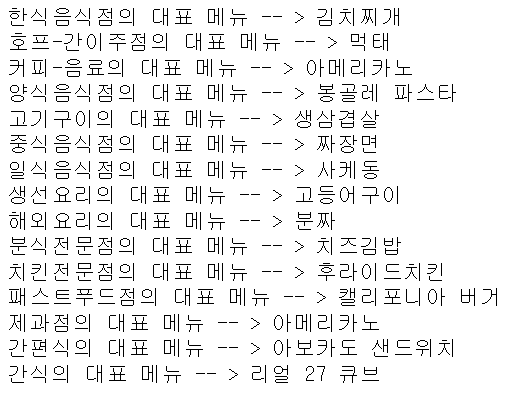

In [8]:
# 상권을 달리하여 업종 별로 대표 5개 메뉴를 선정하여 평균 가격을 추출하고, 이를 category_price_dict_five 에 저장
# 또한 상권을 달리하여 업종 별로 대표 1개 메뉴를 선정하여 평균 가격을 추출하고, 이를 category_price_dict_one 에 저장

category_price_dict_five = dict()
category_price_dict_one = dict()


# 6개의 상권 순회
for i in range(6):
    d_five = dict()
    d_one = dict()
    for category in list(df_store['category'].value_counts().index):
    
        total_price_five = 0
        total_menu_five = 0
        
        total_price_one = 0
        total_menu_one = 0
    
        if category == '제외':
            continue
        
        current_df = df_store[df_store['category'] == category]
        current_df = current_df[current_df['did'] == i]
    
        for menus in current_df['menu']:
            if menus:
                menu_list = menus.split(',')
                for menu in menu_list:
                    idx = menu.find(':')
                    menu_name = menu[:idx]
                    # Top 5 메뉴 추출
                    if menu_name in rep_menu[category] and menu[idx+1] != '변':
                        idx2 = menu.find('~')
                        if idx2 != -1:
                            total_price_five += int(menu[idx+1:idx2])
                        else:
                            total_price_five += int(menu[idx+1:])
                        total_menu_five += 1
                    
                    # Top 1 메뉴 추출
                    if menu_name == rep_menu[category][0] and menu[idx+1] != '변':
                        idx3 = menu.find('~')
                        if idx3 != -1:
                            total_price_one += int(menu[idx+1:idx3])
                        else:
                            total_price_one += int(menu[idx+1:])
                        total_menu_one += 1
        
        # 상권에 그 업종의 대표 메뉴가 있다면, d_five 딕셔너리에 그 업종의 평균 가격, 그리고 그 메뉴를 가지고 있는 음식점 수를 저장
        if total_menu_five > 0:
            d_five[category] = [int(total_price_five/total_menu_five), total_menu_five]
            
        # 상권에 그 업종의 대표 메뉴가 있다면, d_one 딕셔너리에 그 업종의 평균 가격, 그리고 그 메뉴를 가지고 있는 음식점 수를 저장
        if total_menu_one > 0:
            d_one[category] = [int(total_price_one/total_menu_one), total_menu_one]

    # 상권 별로 정리되어 있는 업종별 평균 가격 데이터를 각각의 main dictionary에 저장
    category_price_dict_five[i] = d_five
    category_price_dict_one[i] = d_one

In [9]:
# 대표 5개 메뉴 딕셔너리 키 변경
category_price_dict_five['인사동'] = category_price_dict_five.pop(0)
category_price_dict_five['서래마을'] = category_price_dict_five.pop(1)
category_price_dict_five['샤로수길'] = category_price_dict_five.pop(2)
category_price_dict_five['연남동'] = category_price_dict_five.pop(3)
category_price_dict_five['남대문시장'] = category_price_dict_five.pop(4)
category_price_dict_five['도깨비시장'] = category_price_dict_five.pop(5)

In [10]:
# 대표 1개 메뉴 딕셔너리 키 변경
category_price_dict_one['인사동'] = category_price_dict_one.pop(0)
category_price_dict_one['서래마을'] = category_price_dict_one.pop(1)
category_price_dict_one['샤로수길'] = category_price_dict_one.pop(2)
category_price_dict_one['연남동'] = category_price_dict_one.pop(3)
category_price_dict_one['남대문시장'] = category_price_dict_one.pop(4)
category_price_dict_one['도깨비시장'] = category_price_dict_one.pop(5)

In [11]:
# 메뉴 관련 모든 정보를 저장할 price_df의 인덱스를 리스트 형태로 정리 (MultiIndex)
index1 = []
index2 = []

for i in ['인사동', '서래마을', '샤로수길', '연남동', '남대문시장', '도깨비시장']:
    for j in category_price_dict_five[i].keys():
        index1.append(i)
        index2.append(j)

In [12]:
# price_df 초기 설정
price_df = pd.DataFrame(np.zeros((55, 8)),
    index = [index1, index2],
    columns = ['음식점 수', '매출', 'Top5 메뉴를 가지고 있는 음식점 수', 'Top5 메뉴 평균 가격', 'Top5 메뉴 전체 평균 가격과의 차이', 
               '대표 메뉴를 가지고 있는 음식점 수', '대표 메뉴 평균 가격', '대표 메뉴 전체 평균 가격과의 차이'])

In [13]:
# price_df에 값 넣기.
for idx, i in enumerate(['인사동', '서래마을', '샤로수길', '연남동', '남대문시장', '도깨비시장']):
    for j in category_price_dict_five[i].keys():
        # Top 5 메뉴 가격, 전체 평균과의 차이, 음식점 수
        p1 = int(category_price_dict_five[i][j][0])
        gap1 = p1 - big_category_price_five[j]
        cnt1 = int(category_price_dict_five[i][j][1])
        
        # Top 1 메뉴 가격, 전체 평균과의 차이, 음식점 수
        try:
            p2 = int(category_price_dict_one[i][j][0])
        except:
            p2 = 0
        
        try:
            cnt2 = int(category_price_dict_one[i][j][1])
            gap2 = p2 - big_category_price_one[j]
        except:
            cnt2 = 0
            gap2 = 0
        
        
        temp = df_store[df_store['did'] == idx]
        num = temp[temp['category'] == j]
        
        now = df_competitors[df_competitors['did']==idx]
        sales = now.loc[now['category']==j, 'sales']
        
        # price_df에 값 추가
        try:
            price_df.loc[i, j] = [len(num), int(sales), cnt1, p1, gap1, cnt2, p2, gap2]
        except:
            price_df.loc[i, j] = [len(num), 0, cnt1, p1, gap1,cnt2, p2, gap2]
            
price_df = price_df.astype('int64')

In [14]:
# 전체 평균 가격과의 차이는 양수면 그 지역이 더 비싼거고 음수면 그 지역이 더 싼 것.
price_df

음식점 수           매출  Top5 메뉴를 가지고 있는 음식점 수  Top5 메뉴 평균 가격  \
인사동   한식음식점      152  12763933752                     46          11434   
      호프-간이주점     53   1079929566                     19          15684   
      커피-음료       70   1525310816                     52           4336   
      양식음식점       19    888507668                      3          22500   
      고기구이        25            0                      7          12714   
      중식음식점       14    212993061                     11           7227   
      생선요리        11            0                      8           8437   
      해외요리         9            0                      4          16000   
      분식전문점       10    708047816                      2           3500   
      치킨전문점        6            0                      5          18400   
      제과점          5    205004322                      4           4850   
      간편식          4            0                      6           9750   
      간식           1            0                      6          22483   
서래마을  한식음식점       29   4626620656                      5           7200   
      호프-간이주점     22   1135729063                      1          18000   
      커피-음료        6   1626889576                      4           3875   
      양식음식점        4   5426809638                      1          15000   
      고기구이        15            0                      6          22333   
      중식음식점        5    362033507                      3           7000   
      해외요리         2            0                      2          18500   
      분식전문점        6    452550821                      7           4714   
샤로수길  한식음식점       36  14299395681                      8          12625   
      호프-간이주점     53   2783964294                      2          10500   
      커피-음료       29   1550845586                     34           4529   
      양식음식점       21    836462257                      3          14633   
      고기구이        29            0                     14           8385   
      중식음식점       12   1396935349                      5           6800   
      일식음식점       14   1656405419                      6          10150   
      생선요리         9            0                      2           7500   
      해외요리        11            0                      1          14500   
      분식전문점        4   2826398500                      1           3000   
      치킨전문점        2     56170543                      3          19666   
      패스트푸드점       6    679491644                     10          11200   
연남동   한식음식점      121  13458761609                     10          11300   
      호프-간이주점    210   3932771282                     28          12053   
      커피-음료      173   8007424817                    136           4590   
      양식음식점      102   5049795632                     26          17034   
      고기구이        48            0                     19          10226   
      중식음식점       46   1425578855                     25           6476   
      일식음식점       57   4298991786                     19          14021   
      생선요리        32            0                      7           9071   
      해외요리        36            0                      2          12000   
      분식전문점       18   2327346381                     10           3850   
      치킨전문점       18    399155835                      8          17375   
      제과점         14   1279945646                     11           3854   
      간편식          8            0                      1           9400   
남대문시장 한식음식점       25   3653160236                      6           7166   
      호프-간이주점      1     47674836                      1          13000   
      커피-음료        4   1632552570                      7           3357   
      고기구이         2            0                      2          47000   
      중식음식점        6    622951741                      4           7500   
      생선요리        11            0                     14          10142   
      분식전문점        3    905285424       

In [15]:
# 상관계수 도출
# 도깨비시장의 경우 평균가격 - 매출 쌍이 있는 경우가 하나밖에 없어 상관계수를 도출하지 못함.
# 출력값 순서대로 매출과 Top5 상관계수, 매출과 Top1 상관계수
for i in ['인사동', '서래마을', '샤로수길', '연남동', '남대문시장', '도깨비시장']:
    current_df = price_df.loc[i]
    current_df = current_df[current_df['매출']!=0]
    current_df = current_df.astype('int64')
    print(i, round(current_df.corr().loc['Top5 메뉴 평균 가격', '매출'], 2), round(current_df.corr().loc['대표 메뉴 평균 가격', '매출'], 2), end='\n\n')
        

인사동 0.11 0.14

서래마을 0.3 -0.4

샤로수길 0.01 0.22

연남동 0.05 0.01

남대문시장 -0.32 0.5

도깨비시장 nan nan



## price_df에서 인사이트 도출하기

In [16]:
# 대표 메뉴 가격 차이
L = []
for idx in price_df.index:
    if abs(price_df.loc[idx]['대표 메뉴 전체 평균 가격과의 차이']) > 1000:
        L.append([idx, price_df.loc[idx]['대표 메뉴 전체 평균 가격과의 차이'], price_df.loc[idx]['대표 메뉴를 가지고 있는 음식점 수']])
        
L.sort(key=lambda x:x[1], reverse=True)
for i in L:
    print(f"{i[0]}  대표 메뉴 가격 차이 ->  {i[1]}  대표 메뉴가 있는 음식점 수 ->  {i[2]}")


('서래마을', '호프-간이주점')  대표 메뉴 가격 차이 ->  4000  대표 메뉴가 있는 음식점 수 ->  1
('샤로수길', '한식음식점')  대표 메뉴 가격 차이 ->  3058  대표 메뉴가 있는 음식점 수 ->  3
('연남동', '한식음식점')  대표 메뉴 가격 차이 ->  2391  대표 메뉴가 있는 음식점 수 ->  3
('남대문시장', '중식음식점')  대표 메뉴 가격 차이 ->  2322  대표 메뉴가 있는 음식점 수 ->  1
('인사동', '호프-간이주점')  대표 메뉴 가격 차이 ->  1750  대표 메뉴가 있는 음식점 수 ->  4
('샤로수길', '생선요리')  대표 메뉴 가격 차이 ->  1188  대표 메뉴가 있는 음식점 수 ->  1
('인사동', '고기구이')  대표 메뉴 가격 차이 ->  1110  대표 메뉴가 있는 음식점 수 ->  1
('연남동', '생선요리')  대표 메뉴 가격 차이 ->  -1062  대표 메뉴가 있는 음식점 수 ->  2
('남대문시장', '커피-음료')  대표 메뉴 가격 차이 ->  -1209  대표 메뉴가 있는 음식점 수 ->  2
('남대문시장', '한식음식점')  대표 메뉴 가격 차이 ->  -1275  대표 메뉴가 있는 음식점 수 ->  2
('인사동', '치킨전문점')  대표 메뉴 가격 차이 ->  -1400  대표 메뉴가 있는 음식점 수 ->  1
('샤로수길', '양식음식점')  대표 메뉴 가격 차이 ->  -1488  대표 메뉴가 있는 음식점 수 ->  2
('연남동', '호프-간이주점')  대표 메뉴 가격 차이 ->  -1572  대표 메뉴가 있는 음식점 수 ->  7
('샤로수길', '중식음식점')  대표 메뉴 가격 차이 ->  -1678  대표 메뉴가 있는 음식점 수 ->  1
('서래마을', '한식음식점')  대표 메뉴 가격 차이 ->  -2025  대표 메뉴가 있는 음식점 수 ->  2


In [17]:
# Top 5 메뉴 의존도 높은 곳
L = []
for idx in price_df.index:
    if price_df.loc[idx]['Top5 메뉴를 가지고 있는 음식점 수'] / price_df.loc[idx]['음식점 수'] > 0.7:
        L.append([idx, price_df.loc[idx]['Top5 메뉴를 가지고 있는 음식점 수'] / price_df.loc[idx]['음식점 수'] ,
                  price_df.loc[idx]['Top5 메뉴를 가지고 있는 음식점 수'], price_df.loc[idx]['음식점 수']])
        
L.sort(key=lambda x:x[1], reverse=True)
for i in L:
    if i[3] > 3:
        print(f"{i[0]}  Top 5 메뉴 의존도 ->  {round(i[1], 2)}  Top 5 메뉴 수 ->  {i[2]}  음식점 수 -> {i[3]}")

('남대문시장', '커피-음료')  Top 5 메뉴 의존도 ->  1.75  Top 5 메뉴 수 ->  7  음식점 수 -> 4
('샤로수길', '패스트푸드점')  Top 5 메뉴 의존도 ->  1.67  Top 5 메뉴 수 ->  10  음식점 수 -> 6
('인사동', '간편식')  Top 5 메뉴 의존도 ->  1.5  Top 5 메뉴 수 ->  6  음식점 수 -> 4
('남대문시장', '생선요리')  Top 5 메뉴 의존도 ->  1.27  Top 5 메뉴 수 ->  14  음식점 수 -> 11
('샤로수길', '커피-음료')  Top 5 메뉴 의존도 ->  1.17  Top 5 메뉴 수 ->  34  음식점 수 -> 29
('서래마을', '분식전문점')  Top 5 메뉴 의존도 ->  1.17  Top 5 메뉴 수 ->  7  음식점 수 -> 6
('인사동', '치킨전문점')  Top 5 메뉴 의존도 ->  0.83  Top 5 메뉴 수 ->  5  음식점 수 -> 6
('인사동', '제과점')  Top 5 메뉴 의존도 ->  0.8  Top 5 메뉴 수 ->  4  음식점 수 -> 5
('연남동', '커피-음료')  Top 5 메뉴 의존도 ->  0.79  Top 5 메뉴 수 ->  136  음식점 수 -> 173
('인사동', '중식음식점')  Top 5 메뉴 의존도 ->  0.79  Top 5 메뉴 수 ->  11  음식점 수 -> 14
('연남동', '제과점')  Top 5 메뉴 의존도 ->  0.79  Top 5 메뉴 수 ->  11  음식점 수 -> 14
('인사동', '커피-음료')  Top 5 메뉴 의존도 ->  0.74  Top 5 메뉴 수 ->  52  음식점 수 -> 70
('인사동', '생선요리')  Top 5 메뉴 의존도 ->  0.73  Top 5 메뉴 수 ->  8  음식점 수 -> 11


In [18]:
# Top 5 메뉴 의존도 낮은 곳
L = []
for idx in price_df.index:
    if price_df.loc[idx]['Top5 메뉴를 가지고 있는 음식점 수'] / price_df.loc[idx]['음식점 수'] < 0.2:
        L.append([idx, price_df.loc[idx]['Top5 메뉴를 가지고 있는 음식점 수'] / price_df.loc[idx]['음식점 수'] ,
                  price_df.loc[idx]['Top5 메뉴를 가지고 있는 음식점 수'], price_df.loc[idx]['음식점 수']])
        
L.sort(key=lambda x:x[1], reverse=True)
for i in L:
    if i[3] > 3:
        print(f"{i[0]}  Top 5 메뉴 의존도 ->  {round(i[1], 2)}  Top 5 메뉴 수 ->  {i[2]}  음식점 수 -> {i[3]}")

('서래마을', '한식음식점')  Top 5 메뉴 의존도 ->  0.17  Top 5 메뉴 수 ->  5  음식점 수 -> 29
('인사동', '양식음식점')  Top 5 메뉴 의존도 ->  0.16  Top 5 메뉴 수 ->  3  음식점 수 -> 19
('샤로수길', '양식음식점')  Top 5 메뉴 의존도 ->  0.14  Top 5 메뉴 수 ->  3  음식점 수 -> 21
('연남동', '호프-간이주점')  Top 5 메뉴 의존도 ->  0.13  Top 5 메뉴 수 ->  28  음식점 수 -> 210
('연남동', '간편식')  Top 5 메뉴 의존도 ->  0.12  Top 5 메뉴 수 ->  1  음식점 수 -> 8
('샤로수길', '해외요리')  Top 5 메뉴 의존도 ->  0.09  Top 5 메뉴 수 ->  1  음식점 수 -> 11
('연남동', '한식음식점')  Top 5 메뉴 의존도 ->  0.08  Top 5 메뉴 수 ->  10  음식점 수 -> 121
('연남동', '해외요리')  Top 5 메뉴 의존도 ->  0.06  Top 5 메뉴 수 ->  2  음식점 수 -> 36
('서래마을', '호프-간이주점')  Top 5 메뉴 의존도 ->  0.05  Top 5 메뉴 수 ->  1  음식점 수 -> 22
('샤로수길', '호프-간이주점')  Top 5 메뉴 의존도 ->  0.04  Top 5 메뉴 수 ->  2  음식점 수 -> 53


# V. 인사이트 도출

In [19]:
# 상권별 평균 리뷰 수와 평균 평점 도출 
conn = sqlite3.connect("./data/eatsite.db") # eatsite.db가 저장되어 있는 경로로 지정하면 됨.

try:
    df_rvs_rate=pd.read_sql('''SELECT did, ROUND((SUM(visitor_rvs)+SUM(blog_rvs))/COUNT(sid), 2) as '평균 리뷰 수', ROUND(AVG(rate), 2) as '평균 평점' FROM Store GROUP BY did''', conn)

except sqlite3.Error as err:
    print('SQLite ERROR:', err)
finally:  
    conn.close()  

df_rvs_rate.set_index('did', inplace=True)
df_rvs_rate.index = ['인사동', '서래마을', '샤로수길', '연남동', '남대문시장', '도깨비시장']
df_rvs_rate

,평균 리뷰 수,평균 평점
인사동,408.38,4.37
서래마을,125.50,4.39
샤로수길,464.46,4.48
연남동,244.28,4.53
남대문시장,255.52,4.30
도깨비시장,328.76,4.40


In [20]:
# 상권별 한식음식점 비율
for idx, per in zip(df.loc['한식음식점'].index, df.loc['한식음식점']):
    print(idx, '한식음식점 비율 : ', round(per, 2), '%')

NameError: name 'df' is not defined

In [ ]:
# 상권별 호프-간이주점 비율
for idx, per in zip(df.loc['호프-간이주점'].index, df.loc['호프-간이주점']):
    print(idx, '호프-간이주점 비율 : ', round(per, 2), '%')

In [ ]:
# 상권별 양식음식점 비율
for idx, per in zip(df.loc['양식음식점'].index, df.loc['양식음식점']):
    print(idx, '양식음식점 비율 : ', round(per, 2), '%')